# Neural Object Detection: Practice
## Part 2: SSD training

*Ilya Zakharkin, November 2020*

---
### This notebook requires a GPU runtime to run.
### Please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"
---

Previous year there was a [good Computer Vision practice lesson](https://www.youtube.com/watch?v=XSPYe4-y4HE) (RUS), its [notebooks](https://drive.google.com/drive/folders/1ZpS8oyI__3QvjoIwVZwur4I5e4qIExPS?usp=sharing).

This year we will master inference and training of the SSD neural network discussed on the lecture.

This notebook is based on [mmdetection colab tutorial](https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb).

# MMDetection Tutorial

Welcome to MMDetection! This is the official colab tutorial for using MMDetection. In this tutorial, you will learn
- Perform inference with a MMDet detector.
- Train a new detector with a new dataset.

Let's start!


## Install MMDetection

In [5]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
!nvidia-smi

Sun Nov 29 08:29:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 26kB/s 
     |████████████████████████████████| 6.6MB 42kB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 256kB 15.3MB/s 
     |████████████████████████████████| 194kB 16.4MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.2.1-cp36-cp36m-linux_x86_64.whl size=20354138 sha256=68454895276f0abf53150fef147fac59e834adf6d5a282ba195ba422318bb3c6
  Stored in directory: /root/.cache/pip/wheels/41/0b/39/0cec97174407144208eed51efda0169de0860c0b8460ed0855
Successfully built mmcv-full
Cloning into 'mmdetection'...
remote: Enumerating objects: 14662, done.
remote: Total 14662 (delta 0), reused 0 (delt

In [6]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.5.1+cu101 True
2.6.0
10.1
GCC 7.5


## Perform inference with a MMDet detector
MMDetection already provides high level APIs to do inference and training.

Let's compare two models: Mask-RCNN (more heavy model) and SSD300 (more lightweight model).

Download the Mask-RCNN weights:

In [7]:
!mkdir checkpoints
!wget -c https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
      -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

--2020-11-29 08:56:30--  https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
Resolving open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)... 52.219.56.27
Connecting to open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)|52.219.56.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177867103 (170M) [application/x-www-form-urlencoded]
Saving to: ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’

checkpoints/mask_rc 100%[===================>] 169.63M  16.7MB/s    in 12s     

2020-11-29 08:56:42 (14.6 MB/s) - ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’ saved [177867103/177867103]



Download the SSD300 weights:

In [8]:
!wget -c http://download.openmmlab.com/mmdetection/v2.0/ssd/ssd300_coco/ssd300_coco_20200307-a92d2092.pth \
      -O checkpoints/ssd300_coco_20200307-a92d2092.pth

--2020-11-29 08:56:47--  http://download.openmmlab.com/mmdetection/v2.0/ssd/ssd300_coco/ssd300_coco_20200307-a92d2092.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137237287 (131M) [application/octet-stream]
Saving to: ‘checkpoints/ssd300_coco_20200307-a92d2092.pth’

checkpoints/ssd300_ 100%[===================>] 130.88M  8.86MB/s    in 15s     

2020-11-29 08:57:03 (8.70 MB/s) - ‘checkpoints/ssd300_coco_20200307-a92d2092.pth’ saved [137237287/137237287]



In [9]:
!ls checkpoints

mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
ssd300_coco_20200307-a92d2092.pth


We will use internal API methods for initialization, inference and visualization ofr model predictions:

Mask-RCNN:

In [10]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
config = 'configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
# initialize the detector
model = init_detector(config, checkpoint, device='cuda:0')

In [11]:
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

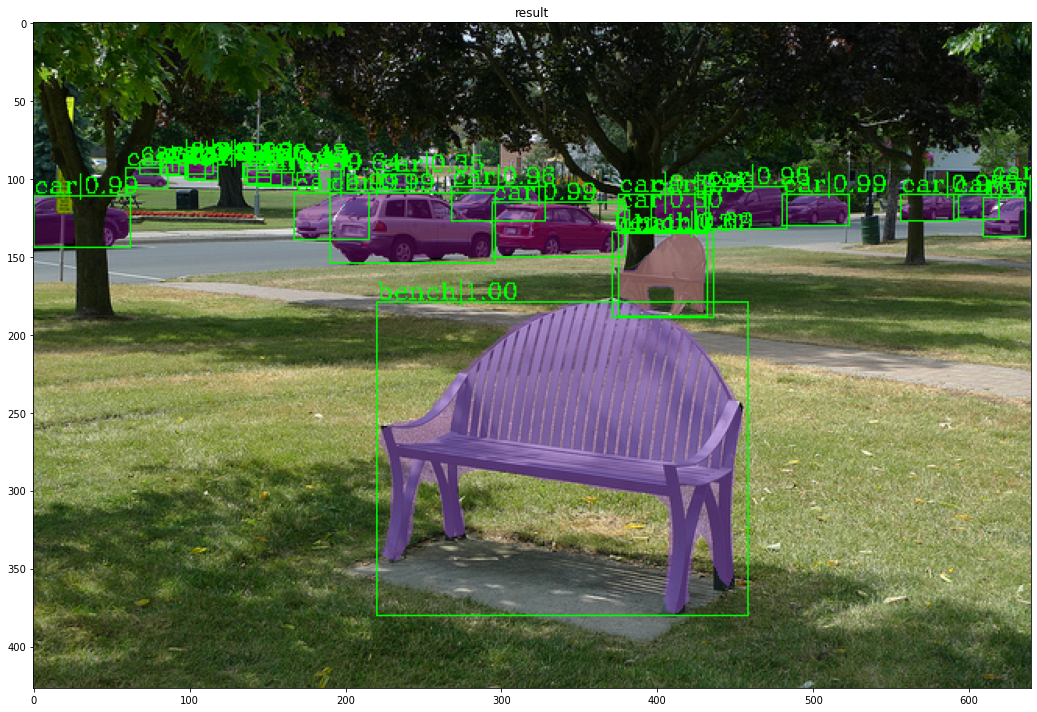

In [12]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)

SSD300:

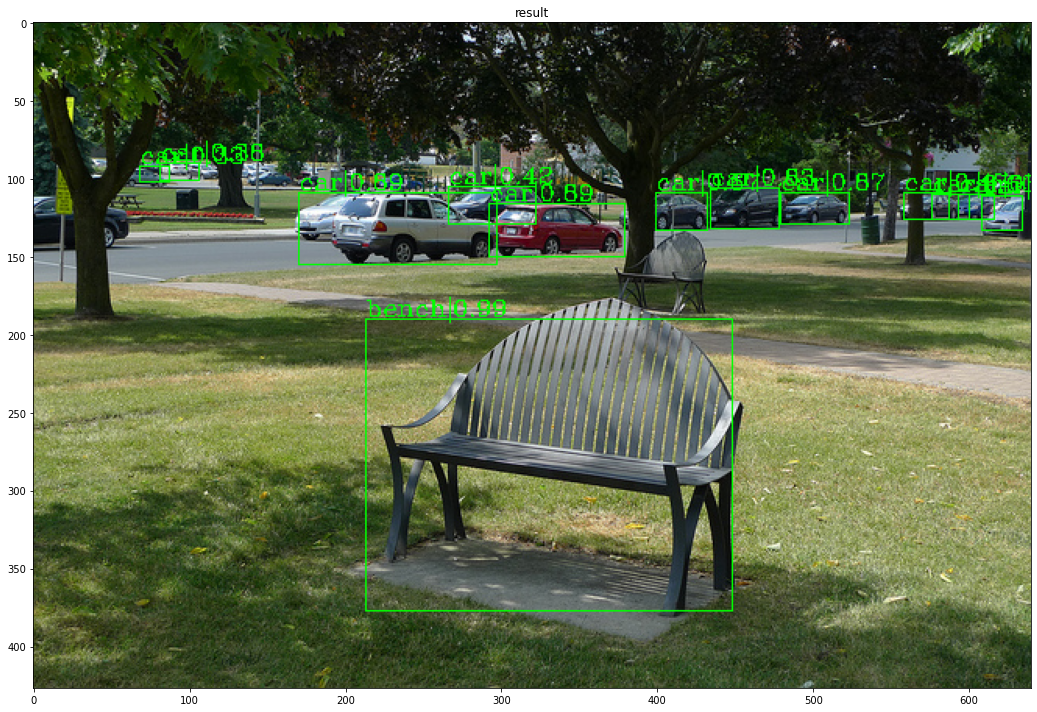

In [13]:
config = 'configs/ssd/ssd300_coco.py'
checkpoint = 'checkpoints/ssd300_coco_20200307-a92d2092.pth'
model = init_detector(config, checkpoint, device='cuda:0')
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

In [14]:
!ls -la checkpoints

total 307736
drwxr-xr-x  2 root root      4096 Nov 29 08:56 .
drwxr-xr-x 16 root root      4096 Nov 29 08:56 ..
-rw-r--r--  1 root root 177867103 May 18  2020 mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
-rw-r--r--  1 root root 137237287 Aug 27 17:44 ssd300_coco_20200307-a92d2092.pth


**Insight**: Mask-RCNN weights 178Mb, and SSD weights 137Mb, and it logically corresponds to their quality: SSD sees less objects on the scenes, therefore it has more False Negatives.

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMDetection: 
  1. reorganize the dataset into COCO format.
  2. reorganize the dataset into a middle format.
  3. implement a new dataset.

Usually we recommend to use the first two methods which are usually easier than the third.

In this tutorial, we gives an example that converting the data into the format of existing datasets like COCO, VOC, etc. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/tutorials/new_dataset.html#).

Firstly, let's download a tiny dataset obtained from [KITTI](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d). We select the first 75 images and their annotations from the 3D object detection dataset (it is the same dataset as the 2D object detection dataset but has 3D annotations). We convert the original images from PNG to JPEG format with 80% quality to reduce the size of dataset.

In [15]:
# download, decompress the data
!wget https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2020-11-29 09:07:41--  https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/data/kitti_tiny.zip
Resolving open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)... 52.219.56.83
Connecting to open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)|52.219.56.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  4.06MB/s    in 1.6s    

2020-11-29 09:07:44 (4.06 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



In [16]:
# Check the directory structure of the tiny data

# Install tree first
!apt-get -q install tree
!tree kitti_tiny

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (131 kB/s)
Selecting previously unselected package tree.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
kitti_tiny
├── training
│   ├── image_2
│   │   ├── 000000.jpeg
│   │   ├── 000001.jpeg
│   │   ├── 000002.jpeg
│   │   ├── 000003.jpeg
│   │   ├── 000004.jpeg
│   │   ├── 000005.jpeg
│   │   ├── 000006.jpeg
│   │   ├── 000007.jpeg
│   │   ├── 000008.jpeg
│   │   ├── 000009.jpeg
│   │   ├── 00

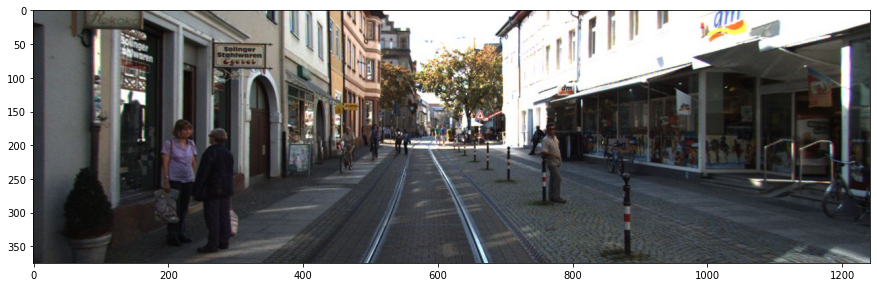

In [17]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('kitti_tiny/training/image_2/000073.jpeg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

After downloading the data, we need to implement a function to convert the kitti annotation format into the middle format. In this tutorial we choose to convert them in **`load_annotations`** function in a newly implemented **`KittiTinyDataset`**.

Let's take a look at the annotation txt file.



In [18]:
# Check the label of a single image
!cat kitti_tiny/training/label_2/000000.txt

Pedestrian 0.00 0 -0.20 712.40 143.00 810.73 307.92 1.89 0.48 1.20 1.84 1.47 8.41 0.01


According to the KITTI's documentation, the first column indicates the class of the object, and the 5th to 8th columns indicates the bboxes. We need to read annotations of each image and convert them into middle format MMDetection accept is as below:

```python
[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray> (n, 4),
            'labels': <np.ndarray> (n, ),
            'bboxes_ignore': <np.ndarray> (k, 4), (optional field)
            'labels_ignore': <np.ndarray> (k, 4) (optional field)
        }
    },
    ...
]
```

In [19]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class KittiTinyDataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpeg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [20]:
from mmcv import Config

model_type = "ssd"

if model_type == "ssd":
  cfg = Config.fromfile('./configs/ssd/ssd300_coco.py')
elif model_type == "mask_rcnn":
  cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

In [23]:
cfg["data"]

{'samples_per_gpu': 8,
 'test': {'ann_file': 'data/coco/annotations/instances_val2017.json',
  'img_prefix': 'data/coco/val2017/',
  'pipeline': [{'type': 'LoadImageFromFile'},
   {'flip': False,
    'img_scale': (300, 300),
    'transforms': [{'keep_ratio': False, 'type': 'Resize'},
     {'mean': [123.675, 116.28, 103.53],
      'std': [1, 1, 1],
      'to_rgb': True,
      'type': 'Normalize'},
     {'keys': ['img'], 'type': 'ImageToTensor'},
     {'keys': ['img'], 'type': 'Collect'}],
    'type': 'MultiScaleFlipAug'}],
  'type': 'CocoDataset'},
 'train': {'dataset': {'ann_file': 'data/coco/annotations/instances_train2017.json',
   'img_prefix': 'data/coco/train2017/',
   'pipeline': [{'to_float32': True, 'type': 'LoadImageFromFile'},
    {'type': 'LoadAnnotations', 'with_bbox': True},
    {'brightness_delta': 32,
     'contrast_range': (0.5, 1.5),
     'hue_delta': 18,
     'saturation_range': (0.5, 1.5),
     'type': 'PhotoMetricDistortion'},
    {'mean': [123.675, 116.28, 103.53],

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.


> - [SSD training issue 1](https://github.com/open-mmlab/mmdetection/issues/1203)
- [SSD training issue 2](https://github.com/open-mmlab/mmdetection/issues/2448)

In [25]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'KittiTinyDataset'
cfg.data_root = 'kitti_tiny/'

cfg.data.test.type = 'KittiTinyDataset'
cfg.data.test.data_root = 'kitti_tiny/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/image_2'

if model_type == "ssd":
  cfg.data.train.dataset.type = 'KittiTinyDataset'
  cfg.data.train.dataset.data_root = 'kitti_tiny/'
  cfg.data.train.dataset.ann_file = 'train.txt'
  cfg.data.train.dataset.img_prefix = 'training/image_2'
elif model_type == "mask_rcnn":
  cfg.data.train.type = 'KittiTinyDataset'
  cfg.data.train.data_root = 'kitti_tiny/'
  cfg.data.train.ann_file = 'train.txt'
  cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittiTinyDataset'
cfg.data.val.data_root = 'kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

if model_type == "ssd":
  cfg.model.bbox_head.num_classes = 3
  cfg.load_from = 'checkpoints/ssd300_coco_20200307-a92d2092.pth'
elif model_type == "mask_rcnn":
  cfg.model.roi_head.bbox_head.num_classes = 3
  cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# ssd300_coco and ssd300_voc with 4gpu, 24 imgs per gpu and lr of 3e-3
cfg.optimizer.lr = 0.02 / 8.  # 3e-3
# cfg.lr_config.warmup = None
cfg.lr_config.warmup_ratio = 1.0 / 1e10
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
input_size = 300
model = dict(
    type='SingleStageDetector',
    pretrained='open-mmlab://vgg16_caffe',
    backbone=dict(
        type='SSDVGG',
        input_size=300,
        depth=16,
        with_last_pool=False,
        ceil_mode=True,
        out_indices=(3, 4),
        out_feature_indices=(22, 34),
        l2_norm_scale=20),
    neck=None,
    bbox_head=dict(
        type='SSDHead',
        in_channels=(512, 1024, 512, 256, 256, 256),
        num_classes=3,
        anchor_generator=dict(
            type='SSDAnchorGenerator',
            scale_major=False,
            input_size=300,
            basesize_ratio_range=(0.15, 0.9),
            strides=[8, 16, 32, 64, 100, 300],
            ratios=[[2], [2, 3], [2, 3], [2, 3], [2], [2]]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[0.1, 0.1, 0.2, 0.2])))
cudnn_benchmark = True
train_cfg = dict(
    assigner=dict(
        type='MaxI

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [26]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/content/mmdetection/mmdet/datasets/custom.py:154: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')
2020-11-29 09:24:55,631 - mmdet - INFO - load model from: open-mmlab://vgg16_caffe
Downloading: "https://download.openmmlab.com/pretrain/third_party/vgg16_caffe-292e1171.pth" to /root/.cache/torch/checkpoints/vgg16_caffe-292e1171.pth


2020-11-29 09:25:06,808 - mmdet - WARNING - The model and loaded state dict do not match exactly

missing keys in source state_dict: extra.0.weight, extra.0.bias, extra.1.weight, extra.1.bias, extra.2.weight, extra.2.bias, extra.3.weight, extra.3.bias, extra.4.weight, extra.4.bias, extra.5.weight, extra.5.bias, extra.6.weight, extra.6.bias, extra.7.weight, extra.7.bias, l2_norm.weight



2020-11-29 09:25:07,039 - mmdet - INFO - load checkpoint from checkpoints/ssd300_coco_20200307-a92d2092.pth
2020-11-29 09:25:07,120 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.cls_convs.0.weight: copying a param with shape torch.Size([324, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 512, 3, 3]).
size mismatch for bbox_head.cls_convs.0.bias: copying a param with shape torch.Size([324]) from checkpoint, the shape in current model is torch.Size([16]).
size mismatch for bbox_head.cls_convs.1.weight: copying a param with shape torch.Size([486, 1024, 3, 3]) from checkpoint, the shape in current model is torch.Size([24, 1024, 3, 3]).
size mismatch for bbox_head.cls_convs.1.bias: copying a param with shape torch.Size([486]) from checkpoint, the shape in current model is torch.Size([24]).
size mismatch for bbox_head.cls_convs.2.weight: copying a param with shape torch.Size([486, 512, 3, 3]) from checkpoint,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 28.8 task/s, elapsed: 1s, ETA:     0s

2020-11-29 09:28:06,431 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 4303 | 0.871  | 0.647 |
| Pedestrian | 13  | 501  | 0.615  | 0.059 |
| Cyclist    | 7   | 196  | 0.000  | 0.000 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.235 |
+------------+-----+------+--------+-------+
2020-11-29 09:28:06,434 - mmdet - INFO - Epoch(val) [12][32]	mAP: 0.2354
2020-11-29 09:28:13,568 - mmdet - INFO - Epoch [13][10/32]	lr: 1.965e-03, eta: 0:02:46, time: 0.696, data_time: 0.331, memory: 1611, loss_cls: 1.8912, loss_bbox: 1.0837, loss: 2.9749
2020-11-29 09:28:17,083 - mmdet - INFO - Epoch [13][20/32]	lr: 2.015e-03, eta: 0:02:41, time: 0.352, data_time: 0.028, memory: 1611, loss_cls: 1.8162, loss_bbox: 1.0697, loss: 2.8859
2020-11-29 09:28:20,718 - mmdet - INFO - Epoch [13][30/32]	lr: 2.065e-03, eta: 0:02:36, time: 0.363, data_time: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 29.6 task/s, elapsed: 1s, ETA:     0s

2020-11-29 09:31:03,459 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 1396 | 0.887  | 0.732 |
| Pedestrian | 13  | 602  | 0.538  | 0.222 |
| Cyclist    | 7   | 143  | 0.143  | 0.001 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.318 |
+------------+-----+------+--------+-------+
2020-11-29 09:31:03,462 - mmdet - INFO - Epoch(val) [24][32]	mAP: 0.3185


### Understand the log
From the log, we can have a basic understanding the training process and know how well the detector is trained.

Firstly, the ResNet-50 backbone pre-trained on ImageNet is loaded, this is a common practice since training from scratch is more cost. The log shows that all the weights of the ResNet-50 backbone are loaded except the `conv1.bias`, which has been merged into `conv.weights`.

Second, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the detector we actually using is Faster R-CNN, the weights in mask branch, e.g. `roi_head.mask_head`, are `unexpected key in source state_dict` and not loaded.
The original Mask R-CNN is trained on COCO dataset which contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layer of the pre-trained Mask R-CNN for classification has different weight shape and is not used.

Third, after training, the detector is evaluated by the default VOC-style evaluation. The results show that the detector achieves 54.1 mAP on the val dataset,
 not bad!

## Test the trained detector

After finetuning the detector, let's visualize the prediction results!

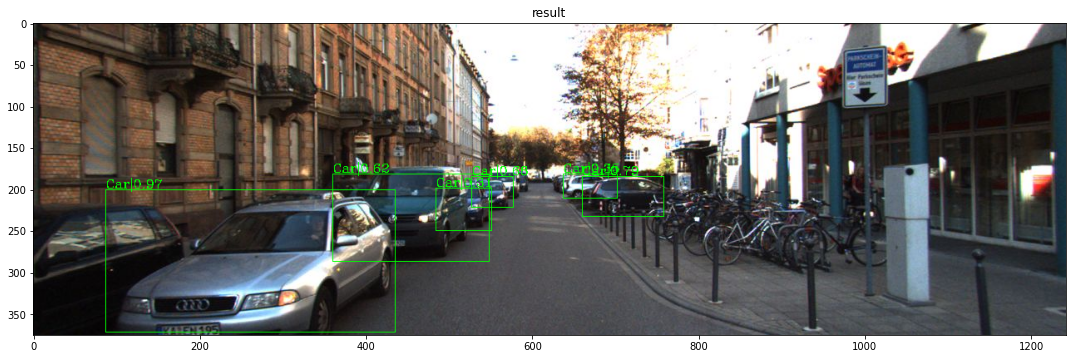

In [27]:
img = mmcv.imread('kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

Feel free to test on your images:

In [ ]:
!wget <your image uri>

In [ ]:
!ls

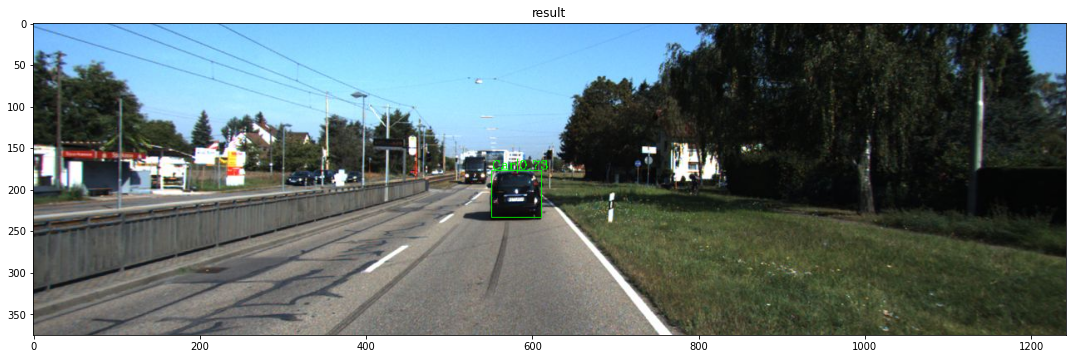

In [28]:
img = mmcv.imread('kitti_tiny/training/image_2/000060.jpeg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

## Useful links

- Andrej Karpathy (Tesla AI director) [keynote on multi-task learning](https://slideslive.com/38917690/multitask-learning-in-the-wilderness) (ENG)
- [CV practice 2019](https://www.youtube.com/watch?v=XSPYe4-y4HE) (RUS)
- [Habrahabr post: Classification & Representation](https://habr.com/ru/company/mipt/blog/458190/) (RUS)
- [Habrahabr post: Detection & Tracking](https://habr.com/ru/company/mipt/blog/450732/) (RUS)
